<a href="https://colab.research.google.com/github/pravsels/paligemma_from_scratch/blob/main/PaliGemma_supplemental_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz

In [1]:
import torch
import torch.nn as nn
from torchviz import make_dot

ModuleNotFoundError: No module named 'torchviz'

In [ ]:
class SuperSimpleModel(nn.Module):
   class_tensor = torch.tensor([4, 5, 6])  # Class attribute

   def __init__(self):
        super().__init__()
        self.instance_tensor = torch.tensor([7, 8, 9])  # Instance attribute
        self.register_buffer('buffer_tensor', torch.tensor([10, 11, 12]))

        self.default_param = nn.Parameter(torch.randn(3))

   def forward(self, x):
        inline_tensor = torch.tensor([13, 14, 15])

        result = x + self.class_tensor * 2 +  \
            self.instance_tensor * 2 +    \
            self.buffer_tensor * 2 +    \
            inline_tensor * 2 + self.default_param

        return result

In [ ]:
x = torch.tensor([1, 2, 3])

model = SuperSimpleModel()

y = model(x)

In [ ]:
model.state_dict()

OrderedDict([('default_param', tensor([0.2109, 0.0087, 0.2786])),
             ('buffer_tensor', tensor([10, 11, 12]))])

In [ ]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

print('listing params : ')
for name, param in model.named_parameters():
    print(name, param.shape)

Total parameters: 3
listing params : 
default_param torch.Size([3])


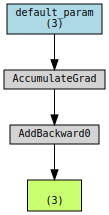

In [ ]:
make_dot(y, params=dict(model.named_parameters()))

In [ ]:
class SimpleModel(nn.Module):
   class_tensor = torch.tensor([4, 5, 6])  # Class attribute

   def __init__(self):
        super().__init__()
        self.instance_tensor = torch.tensor([7, 8, 9])  # Instance attribute
        self.register_buffer('buffer_tensor', torch.tensor([10, 11, 12]))

        self.default_param = nn.Parameter(torch.randn(3))

        # Added layers
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.linear = nn.Linear(16, 3)  # Output size 3 to match other tensors

   def forward(self, x):
        inline_tensor = torch.tensor([13, 14, 15])

        # Process through conv and linear
        x = self.conv(x)  # Expects x shape: [batch, 3, H, W]
        x = x.mean(dim=[2,3])  # Global average pooling to reduce spatial dims
        x = self.linear(x)  # To match size of other tensors

        result = x + self.class_tensor * 2 +  \
            self.instance_tensor * 2 +    \
            self.buffer_tensor * 2 +    \
            inline_tensor * 2 + self.default_param

        return result

In [ ]:
x = torch.randn(1, 3, 32, 32)  # [batch=1, channels=3, height=32, width=32]
x = x.float()

model = SimpleModel()

y = model.forward(x)

In [ ]:
model.state_dict()

OrderedDict([('default_param', tensor([ 0.8787, -0.8073,  0.6710])),
             ('buffer_tensor', tensor([10, 11, 12])),
             ('conv.weight',
              tensor([[[[-1.2175e-01,  1.8980e-01, -1.3006e-01],
                        [ 9.1079e-02,  7.3207e-02,  1.4001e-01],
                        [ 8.6133e-02, -6.9317e-03,  1.5753e-01]],
              
                       [[-1.8307e-01,  1.7288e-02,  1.0325e-01],
                        [ 1.0669e-02,  1.1352e-01, -2.5215e-02],
                        [-5.1842e-02, -1.6308e-02,  9.2067e-03]],
              
                       [[-1.7288e-01,  7.0757e-02,  6.2713e-02],
                        [ 5.7581e-02, -1.2314e-01, -3.6668e-02],
                        [-9.9316e-02,  1.3665e-01, -4.5963e-02]]],
              
              
                      [[[ 1.7256e-01, -1.6920e-01, -1.7107e-01],
                        [-1.0477e-01,  2.6244e-02, -1.0988e-01],
                        [ 8.2875e-02, -1.7794e-01,  1.8268e-01]],
   

In [ ]:
# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

print('listing params : ')
for name, param in model.named_parameters():
    print(name, param.shape)

Total parameters: 502
listing params : 
default_param torch.Size([3])
conv.weight torch.Size([16, 3, 3, 3])
conv.bias torch.Size([16])
linear.weight torch.Size([3, 16])
linear.bias torch.Size([3])


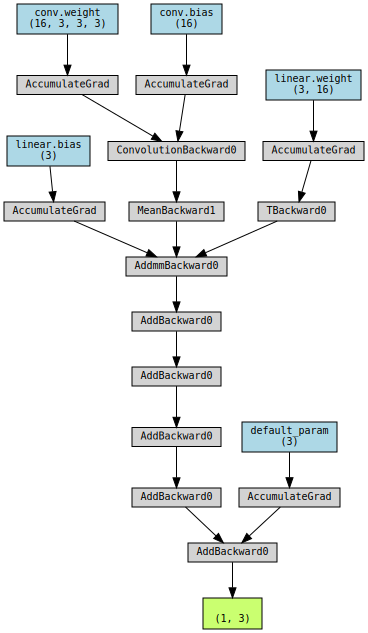

In [ ]:
make_dot(y, params=dict(model.named_parameters()))

Regular tensors are only added to PyTorch's computation graph if they either:

*   Are registered as `nn.Parameter`
*   Have `requires_grad=True`
*   Result from operations involving tensors that require gradients

Furthermore, there's a key difference between:

* Being in computation graph (`requires_grad=True`): Gets gradients during backprop
* Being in `model.parameters()`: Gets both gradients **AND** optimizer updates

This is why we register trainable weights as `nn.Parameter` rather than just using `requires_grad=True` on regular tensors.

All other tensors (instance attributes, class attributes, global variables, buffers) are not tracked for automatic differentiation.

# Torch contiguous experiments

Understanding **stride**

In [28]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
print(f"Original tensor x:\n{x}\n")
print('stride : ', x.stride())

Original tensor x:
tensor([[1., 2., 3.],
        [4., 5., 6.]])

stride :  (3, 1)


The stride values (3, 1) for this tensor of shape [2, 3] tell us exactly how the elements are laid out in memory:

The first value 3 is the stride for the first dimension (rows).

This means when you move down one row, you need to jump 3 elements in the linear memory.

The second value 1 is the stride for the second dimension (columns). This means when you move right one column, you need to jump 1 element in the linear memory.

Let's visualize how this maps a 2×3 tensor to a linear memory array:
If we have a tensor that looks like:
```
[  
  [a, b, c],
  [d, e, f]
]
```

With strides (3, 1), the elements are stored in memory as:
```
[a, b, c, d, e, f]
```


In [7]:
y = x.transpose(0, 1)
print("\n===== AFTER TRANSPOSE =====")
print(f"Transposed tensor y:\n{y}")
print(f"New shape: {y.shape}")
print(f"New strides: {y.stride()}")
print(f"New is contiguous: {y.is_contiguous()}")
print(f"Still using same storage?: {x.storage().data_ptr() == y.storage().data_ptr()}")


===== AFTER TRANSPOSE =====
Transposed tensor y:
tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])
New shape: torch.Size([3, 2])
New strides: (1, 3)
New is contiguous: False
Still using same storage?: True


The transposed tensor logically looks like:
```
[
  [a, d],
  [b, e],
  [c, f]
]
```

But the underlying storage is still the same linear array:
```
[a, b, c, d, e, f]
```

In [8]:
def is_same_tensor(t1, t2):
    """Check if two tensors share the same underlying storage."""
    return t1.storage().data_ptr() == t2.storage().data_ptr()

def print_tensor_info(name, tensor):
    """Print information about a tensor's memory layout."""
    print(f"\n{name}:")
    print(f"  Shape: {tensor.shape}")
    print(f"  Strides: {tensor.stride()}")
    print(f"  Storage offset: {tensor.storage_offset()}")
    print(f"  Is contiguous: {tensor.is_contiguous()}")
    print(f"  Memory address: {tensor.data_ptr()}")

## **Example 1, Tensor slicing**



In [9]:
original = torch.arange(12).reshape(3, 4)
print_tensor_info("Original tensor", original)


Original tensor:
  Shape: torch.Size([3, 4])
  Strides: (4, 1)
  Storage offset: 0
  Is contiguous: True
  Memory address: 129634816


In [29]:
print(original)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


In [11]:
sliced = original[:2, :2]
print_tensor_info("Sliced tensor", sliced)


Sliced tensor:
  Shape: torch.Size([2, 2])
  Strides: (4, 1)
  Storage offset: 0
  Is contiguous: False
  Memory address: 129634816


In [24]:
print(sliced)

tensor([[0, 1],
        [4, 5]])


In [12]:
sliced_contiguous = sliced.contiguous()
print_tensor_info("Sliced after .contiguous()", sliced_contiguous)
print(f"Sliced and its .contiguous() share storage: {is_same_tensor(sliced, sliced_contiguous)}")


Sliced after .contiguous():
  Shape: torch.Size([2, 2])
  Strides: (2, 1)
  Storage offset: 0
  Is contiguous: True
  Memory address: 130007168
Sliced and its .contiguous() share storage: False


## **Example 2, Tensor tranpose**



In [13]:
transposed = original.transpose(0, 1)
print_tensor_info("Transposed tensor (non-contiguous)", transposed)


Transposed tensor (non-contiguous):
  Shape: torch.Size([4, 3])
  Strides: (1, 4)
  Storage offset: 0
  Is contiguous: False
  Memory address: 129634816


In [14]:
transposed_contiguous = transposed.contiguous()
print_tensor_info("Transposed after .contiguous()", transposed_contiguous)
print(f"Transposed and its .contiguous() share storage: {is_same_tensor(transposed, transposed_contiguous)}")


Transposed after .contiguous():
  Shape: torch.Size([4, 3])
  Strides: (3, 1)
  Storage offset: 0
  Is contiguous: True
  Memory address: 130642624
Transposed and its .contiguous() share storage: False


In [16]:
print("\nMemory layout visualization:")
print("Original tensor memory layout:")
print(original.storage())


Memory layout visualization:
Original tensor memory layout:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 12]


In [23]:
print("\nTransposed tensor (logical view):")
print(transposed)
print("\nTransposed tensor storage:")
print(transposed.storage())
print(transposed.is_contiguous())


Transposed tensor (logical view):
tensor([[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]])

Transposed tensor storage:
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 12]
False


In [19]:
print("\nTransposed and made contiguous (actual memory rearranged):")
print(transposed_contiguous.storage())


Transposed and made contiguous (actual memory rearranged):
 0
 4
 8
 1
 5
 9
 2
 6
 10
 3
 7
 11
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 12]
